analysis section

In [ ]:
import requests

In [ ]:
base_url= "https://e2277aeb04e5.ngrok-free.app"

In [ ]:
import requests

url = f"{base_url}/stocks"
params = {
    "StartDate": "2010-01-01",
    "EndDate": "2025-08-07",
    "Ticker": "688707.SS",
    "Fields": ["timestamp","close"]
}

response = requests.get(url, params=params)

# If the response is JSON
data = response.json()
print(data)


[{'_id': {'$oid': '68937d2de8cb789dfb8bbd44'}, 'close': 45.41792678833008, 'timestamp': {'$date': '2021-09-13T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd45'}, 'close': 45.253536224365234, 'timestamp': {'$date': '2021-09-14T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd46'}, 'close': 39.26808547973633, 'timestamp': {'$date': '2021-09-15T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd47'}, 'close': 37.672607421875, 'timestamp': {'$date': '2021-09-16T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd48'}, 'close': 37.69194412231445, 'timestamp': {'$date': '2021-09-21T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd49'}, 'close': 35.97076416015625, 'timestamp': {'$date': '2021-09-22T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd4a'}, 'close': 36.00944519042969, 'timestamp': {'$date': '2021-09-23T16:00:00Z'}}, {'_id': {'$oid': '68937d2de8cb789dfb8bbd4b'}, 'close': 33.679080963134766, 'timestamp': {'$date': '2021-09-26T16:00:00Z'}}, {'_id': {'$oid'

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

def build_daily_close_array(documents):
    # Convert list of dicts to DataFrame
    records = []
    for doc in documents:
        ts_str = doc["timestamp"]["$date"]
        ts = pd.to_datetime(ts_str).date()
        close = doc["close"]
        records.append((ts, close))
    #print(records)
    df = pd.DataFrame(records, columns=["timestamp", "close"])
    df.set_index("timestamp", inplace=True)

    # Create full date range from 2010-01-01 to today
    full_range = pd.date_range(start="2010-01-01", end=datetime.today(), freq="D")

    # # Reindex to full range, fill missing with NaN
    df_full = df.reindex(full_range)
    df_full.index.name = "timestamp"

    # Return as 1D NumPy array
    return df_full["close"].to_numpy()
    #return df_full


In [ ]:
all_stocks = pd.read_csv("/content/sse_stock.csv")
all_stocks= all_stocks[all_stocks["Validated"]==1]

In [ ]:
def get_all_stock_data(base_url):
  print("Only getting 120 stocks for now")
  all_stocks = pd.read_csv("/content/sse_stock.csv")
  all_stocks= all_stocks[all_stocks["Validated"]==1]
  unique_stocks = all_stocks["SSE Code"].to_list()[:120]
  array= np.zeros((pd.date_range(start="2010-01-01", end=datetime.today(), freq="D").shape[0], len(unique_stocks)))
  for i, stock in tqdm(enumerate(unique_stocks)):
    url = f"{base_url}/stocks"
    params = {
        "StartDate": "2010-01-01",
        "EndDate": "2025-08-07",
        "Ticker": stock,
        "Fields": ["timestamp","close"]
    }

    response = requests.get(url, params=params)

    # If the response is JSON
    data = response.json()
    arr= build_daily_close_array(data)
    array[:, i]= arr
  return array


In [ ]:
all_stock_data= get_all_stock_data(base_url)

Only getting 120 stocks for now


120it [05:20,  2.67s/it]


In [ ]:
all_stock_data.shape

(5698, 120)

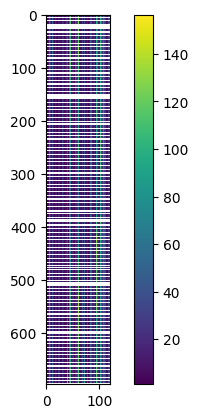

In [ ]:

plt.imshow(all_stock_data[5000:], cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a color bar to show the scale

In [ ]:
np.savetxt("subset.csv", all_stock_data, delimiter= ",", fmt= "%.2f")

Loading subset

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
all_stock_data = np.genfromtxt("subset.csv",delimiter= ",",dtype= np.float32, filling_values=np.nan)[2500:]

In [ ]:
normalized= (all_stock_data- np.nanmin(all_stock_data, axis=0))/ (np.nanmax(all_stock_data, axis=0)- np.nanmin(all_stock_data, axis=0))

In [ ]:
normalized2= np.expand_dims(normalized, axis=1)
normalized= np.expand_dims(normalized, axis=2)
#(normalized-normalized2).shape

In [ ]:
npd = np.nansum((normalized-normalized2)**2, axis=0)

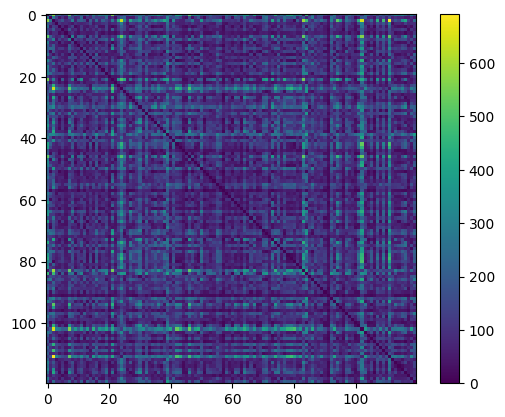

In [ ]:
plt.imshow(npd, cmap='viridis', interpolation='nearest')
plt.colorbar()

In [ ]:
#prepare for clustering
#from itertools import combinations

def prepare_clustering_data(diff_matrix):
    n = diff_matrix.shape[0]
    assert diff_matrix.shape[1] == n, "Matrix must be square"

    labels = []
    X = []

    for i in range(n):
        for j in range(i + 1, n):
            labels.append((i, j))
            X.append(diff_matrix[i, j])

    return labels, np.array(X)

labels, X= prepare_clustering_data(npd)


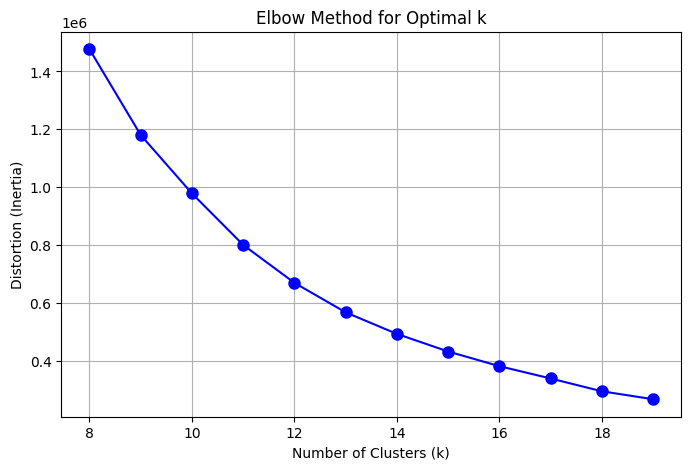

In [ ]:


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs



# Calculate distortions for different numbers of clusters
distortions = []
K = range(8, 20)  # Test cluster numbers from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X.reshape(-1, 1))
    distortions.append(kmeans.inertia_)  # Inertia measures within-cluster sum of squares

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()



In [ ]:
kmeans = KMeans(n_clusters=13, random_state=42, n_init=10)
kmeans.fit(X.reshape(-1, 1))

KMeans(n_clusters=13, n_init=10, random_state=42)

In [ ]:
clusters= pd.DataFrame({"labels":labels, "npd": X, "cluster": list(kmeans.predict(X.reshape(-1, 1)))})

In [ ]:
def get_min_npd_labels_per_cluster(clusters_df):
    # Find index of min npd for each cluster
    min_indices = clusters_df.groupby("cluster")["npd"].idxmin()

    # Extract corresponding rows
    return clusters_df.loc[min_indices, ["labels", "npd", "cluster"]]
selected_pair = get_min_npd_labels_per_cluster(clusters)

In [ ]:
selected_pair

,labels,npd,cluster
6784,"(92, 115)",231.884232,0
6447,"(82, 93)",60.701874,1
550,"(4, 85)",133.356354,2
2097,"(19, 27)",275.357788,3
42,"(0, 43)",396.349762,4
3462,"(33, 97)",83.971916,5
6008,"(71, 116)",194.767380,6
4799,"(51, 57)",5.856598,7
273,"(2, 39)",330.127594,8
1098,"(9, 73)",37.718597,9


In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS



In [ ]:
def test_cointegration(selected_df):
  for index, row in selected_df.iterrows():
    pairs= row["labels"]
    y1= normalized[:, pairs[0]].squeeze()
    y2= normalized[:, pairs[1]].squeeze()
    tmp = pd.DataFrame({"stock1":y1, "stock2":y2})
    clean_array = tmp.dropna().to_numpy()
    #print(clean_array.shape)
    results= sm.tsa.stattools.coint(clean_array[:,0], clean_array[:,1], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)
    print(pairs)
    print(results)

test_cointegration(selected_pair)

(92, 115)
(np.float64(-3.0526009232813225), np.float64(0.0982252355123654), array([-3.90160369, -3.33900821, -3.0464474 ]))
(82, 93)
(np.float64(-3.474768446431845), np.float64(0.03469862120840609), array([-3.90160369, -3.33900821, -3.0464474 ]))
(4, 85)
(np.float64(-3.0834822224689105), np.float64(0.09166879048503879), array([-3.90669509, -3.34184099, -3.04841241]))
(19, 27)
(np.float64(-2.7751734250544366), np.float64(0.17371190949279192), array([-3.90160369, -3.33900821, -3.0464474 ]))
(0, 43)
(np.float64(-1.9205553814931877), np.float64(0.5695461657707837), array([-3.90175918, -3.3390948 , -3.04650748]))
(33, 97)
(np.float64(-1.3232111014935144), np.float64(0.8226218892829934), array([-3.90463173, -3.34069358, -3.04761659]))
(71, 116)
(np.float64(1.251682494851904), 1.0, array([-3.9017386 , -3.33908333, -3.04649952]))
(51, 57)
(np.float64(-2.4886837568367444), np.float64(0.2840825152286612), array([-3.90839689, -3.34278672, -3.04906824]))
(2, 39)
(np.float64(-2.064829185766777), np

Pipeline

In [ ]:
def get_clean_data(stock1idx, stock2idx):
  y1= normalized[:, stock1idx].squeeze()
  y2= normalized[:, stock2idx].squeeze()
  tmp = pd.DataFrame({"stock1":y1, "stock2":y2})
  clean_array = tmp.dropna().to_numpy()
  return clean_array[:,0], clean_array[:,1]

# mr_spy_iwm.py

def calculate_spread_zscore(pairs, symbols, lookback=100):
    """
    Creates a hedge ratio between the two symbols by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    symbols based on a linear combination of the two.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        A DataFrame containing Close price for SPY and IWM. Index is a
        Datetime object.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.
    lookback : `int`, optional (default: 100)
        Lookback preiod for rolling linear regression.

    Returns
    -------
    pairs : 'pd.DataFrame'
        Updated DataFrame containing the spread and z score between
        the two symbols based on the rolling linear regression.
    """

    def adaptive_zscore(series, window):
      zscores = []
      for i in range(len(series)):
          if i == 0:
              zscores.append(0)  # First value is always 0
          else:
              start = max(0, i - window)
              data_window = series[start:i]  # up to but not including i
              mean = data_window.mean()
              std = data_window.std(ddof=0)
              z = (series[i] - mean) / std if std != 0 else 0
              zscores.append(z)
      return pd.Series(zscores, index=series.index)

    # Use the statsmodels Rolling Ordinary Least Squares method to fit
    # a rolling linear regression between the two closing price time series
    print("Fitting the rolling Linear Regression...")

    model = RollingOLS(
        endog=pairs[symbols[0]],
        exog=sm.add_constant(pairs[symbols[1]]),
        window=lookback,
        expanding=True
    )
    rres = model.fit()
    params = rres.params.copy()


    # Construct the hedge ratio and eliminate the first
    # lookback-length empty/NaN period
    pairs['hedge_ratio'] = params[symbols[1]]
    pairs.dropna(inplace=True)

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    pairs['spread'] = (
        pairs[symbols[0]] - pairs['hedge_ratio']*pairs[symbols[1]]
    )
    expanding_df = pairs.expanding()
    pairs['zscore'] = adaptive_zscore(pairs["spread"], lookback)
    pairs.loc[pairs.index[0], "zscore"]=0
    return pairs

# mr_spy_iwm.py

def create_long_short_market_signals(
        pairs, z_entry_threshold=2.0, z_exit_threshold=1.0
    ):
    """
    Create the entry/exit signals based on the exceeding of z_entry_threshold
    for entering a position and falling below z_exit_threshold for exiting
    a position.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        Updated DataFrame containing the close price, spread and z score
        between the two symbols.
    z_entry_threshold : `float`, optional (default:2.0)
        Z Score threshold for market entry.
    z_exit_threshold : `float`, optional (default:1.0)
        Z Score threshold for market exit.

    Returns
    -------
    pairs : `pd.DataFrame`
        Updated DataFrame containing long, short and exit signals.
    """

    # Calculate when to be long, short and when to exit
    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
    pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold)*1.0

    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print("Calculating when to be in the market (long and short)...")
    for i, b in enumerate(pairs.iterrows()):
        # Calculate longs
        if b[1]['longs'] == 1.0:
            long_market = 1
        # Calculate shorts
        if b[1]['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b[1]['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        pairs.at[pairs.index[i], 'long_market'] = long_market
        pairs.at[pairs.index[i], 'short_market'] = short_market

    return pairs

# mr_spy_iwm.py

def create_portfolio_returns(pairs, symbols):
    """
    Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        Updated DataFrame containing the close price, spread and z score
        between the two symbols and the long, short and exit signals.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.

    Returns
    -------
    portfolio : 'pd.DataFrame'
        A DataFrame with datetime index from the pairs DataFrame, positions,
        total market value and returns.
    """

    # Convenience variables for symbols

    # Construct the portfolio object with positions information
    # Note the minuses to keep track of shorts!
    print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=pairs.index)
    portfolio['positions'] = pairs['long_market'] - pairs['short_market']
    portfolio[symbols[0]] = portfolio['positions'] * 1.0 * pairs[symbols[0]]
    portfolio[symbols[1]] = portfolio['positions'] * (-pairs['hedge_ratio']) * pairs[symbols[1]]

    portfolio['total'] = portfolio[symbols[0]] + portfolio[symbols[1]]

    # Construct a percentage returns stream and eliminate all
    # of the NaN and -inf/+inf cells
    entry_spread = None
    position = 0  # 1 for long, -1 for short, 0 for no position
    rewards = []

    for i in range(len(pairs)):
        current_spread = pairs['spread'].iloc[i]
        long_signal = pairs['long_market'].iloc[i]
        short_signal = pairs['short_market'].iloc[i]

        # Entry
        if position == 0:
            if long_signal == 1:
                position = 1
                entry_spread = current_spread
            elif short_signal == 1:
                position = -1
                entry_spread = current_spread
            rewards.append(0.0)

        # Exit
        elif (long_signal == 0 and position == 1) or (short_signal == 0 and position == -1):
            reward = (entry_spread - current_spread) * position
            rewards.append(reward)
            position = 0
            entry_spread = None

        # Hold
        else:
            rewards.append(0.0)

    portfolio['reward'] = rewards

    portfolio['cumulative_reward'] = pd.Series(rewards).cumsum().values

    return portfolio




In [ ]:
s9, s73= get_clean_data(9, 73)
pair = pd.DataFrame({"stock1":s9 , "stock2":s73})
pair= calculate_spread_zscore(pair, ("stock1", "stock2"), lookback=100)
pair= create_long_short_market_signals(pair, z_entry_threshold=1.5, z_exit_threshold= 0.5).copy()
port= create_portfolio_returns(pair, ("stock1", "stock2"))

Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...


In [ ]:
import pandas as pd

# Define parameter grids
lookbacks = [50, 100, 150]
entry_thresholds = [1.0, 1.5, 2.0]
exit_thresholds = [0.5, 1.0]

results = []
s9, s73 = get_clean_data(9, 73)

for lookback in lookbacks:
    for entry in entry_thresholds:
        for exit in exit_thresholds:
            # Prepare data
            pair = pd.DataFrame({"stock1": s9, "stock2": s73})
            pair = calculate_spread_zscore(pair, ("stock1", "stock2"), lookback=lookback)
            pair = create_long_short_market_signals(pair, z_entry_threshold=entry, z_exit_threshold=exit).copy()
            port = create_portfolio_returns(pair, ("stock1", "stock2"))

            # Store result
            final_reward = port['cumulative_reward'].iloc[-1]
            results.append({
                "lookback": lookback,
                "entry_threshold": entry,
                "exit_threshold": exit,
                "final_cumulative_reward": final_reward
            })

# Convert to DataFrame for analysis
grid_results = pd.DataFrame(results)
print(grid_results.sort_values(by="final_cumulative_reward", ascending=False))



Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
    lookback  entry_threshold  exit_threshold  final_cumulative_reward
1         50              1.0             1.0                 2.541757
3         50              1.5             1.0                 2.009374
0         50              1.0             0.5                 1.763826
5         50              2.0             1.0                 1.434635
2         50              1.5             0.5                 1.339719
13       150              1.0             1.0                 1.339005
12       150              1.0             0.5                 1.311705
7        100              1.0             1.0                 1.140622
14       150              1.5             0.5                 1.109775
15       150              1.5             1.0                 0.991574
9        100              1.5             1.0                 0.908159
4         50             

In [ ]:
import pandas as pd

# Define parameter grids
lookbacks = [50, 100, 150]
entry_thresholds = [1.0, 1.5, 2.0]
exit_thresholds = [0.5, 1.0]
results = []
s9, s73 = get_clean_data(4, 85)

for lookback in lookbacks:
    for entry in entry_thresholds:
        for exit in exit_thresholds:
            # Prepare data
            pair = pd.DataFrame({"stock1": s9, "stock2": s73})
            pair = calculate_spread_zscore(pair, ("stock1", "stock2"), lookback=lookback)
            pair = create_long_short_market_signals(pair, z_entry_threshold=entry, z_exit_threshold=exit).copy()
            port = create_portfolio_returns(pair, ("stock1", "stock2"))

            # Store result
            final_reward = port['cumulative_reward'].iloc[-1]
            results.append({
                "lookback": lookback,
                "entry_threshold": entry,
                "exit_threshold": exit,
                "final_cumulative_reward": final_reward
            })

# Convert to DataFrame for analysis
grid_results = pd.DataFrame(results)
print(grid_results.sort_values(by="final_cumulative_reward", ascending=False))



Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
    lookback  entry_threshold  exit_threshold  final_cumulative_reward
1         50              1.0             1.0                 0.021741
9        100              1.5             1.0                -0.066278
14       150              1.5             0.5                -0.213164
8        100              1.5             0.5                -0.218897
15       150              1.5             1.0                -0.267896
7        100              1.0             1.0                -0.284032
6        100              1.0             0.5                -0.335144
12       150              1.0             0.5                -0.373516
13       150              1.0             1.0                -0.384006
5         50              2.0             1.0                -0.413979
11       100              2.0             1.0                -0.442592
3         50             

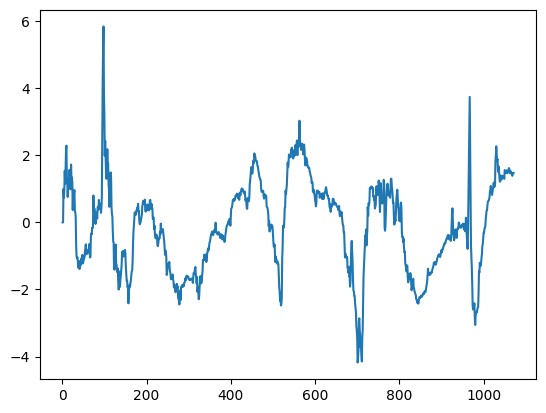

In [ ]:
plt.plot(pair["zscore"])

In [ ]:
# Define parameter grids
lookbacks = [50, 100, 150]
entry_thresholds = [1.0, 1.5, 2.0]
exit_thresholds = [0.5, 1.0]

results = []
s9, s73 = get_clean_data(82, 93)

for lookback in lookbacks:
    for entry in entry_thresholds:
        for exit in exit_thresholds:
            # Prepare data
            pair = pd.DataFrame({"stock1": s9, "stock2": s73})
            pair = calculate_spread_zscore(pair, ("stock1", "stock2"), lookback=lookback)
            pair = create_long_short_market_signals(pair, z_entry_threshold=entry, z_exit_threshold=exit).copy()
            port = create_portfolio_returns(pair, ("stock1", "stock2"))

            # Store result
            final_reward = port['cumulative_reward'].iloc[-1]
            results.append({
                "lookback": lookback,
                "entry_threshold": entry,
                "exit_threshold": exit,
                "final_cumulative_reward": final_reward
            })

# Convert to DataFrame for analysis
grid_results = pd.DataFrame(results)
print(grid_results.sort_values(by="final_cumulative_reward", ascending=False))

Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Calculating when to be in the market (long and short)...
Constructing a portfolio...
Fitting the rolling Linear Regression...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
    lookback  entry_threshold  exit_threshold  final_cumulative_reward
1         50              1.0             1.0                 3.390523
3         50              1.5             1.0                 2.612333
7        100              1.0             1.0                 2.445374
9        100              1.5             1.0                 2.161968
11       100              2.0             1.0                 1.537535
13       150              1.0             1.0                 1.171895
2         50              1.5             0.5                 0.995301
5         50              2.0             1.0                 0.850431
0         50              1.0             0.5                 0.740800
12       150              1.0             0.5                 0.656885
14       150              1.5             0.5                 0.455577
15       150             

Draft below

try with (9, 73)

In [ ]:
def get_clean_data(stock1idx, stock2idx):
  y1= normalized[:, stock1idx].squeeze()
  y2= normalized[:, stock2idx].squeeze()
  tmp = pd.DataFrame({"stock1":y1, "stock2":y2})
  clean_array = tmp.dropna().to_numpy()
  return clean_array[:,0], clean_array[:,1]

s9, s73= get_clean_data(9, 73)
model = LinearRegression()
model.fit(s9.reshape(-1, 1), s73.reshape(-1, 1))

LinearRegression()

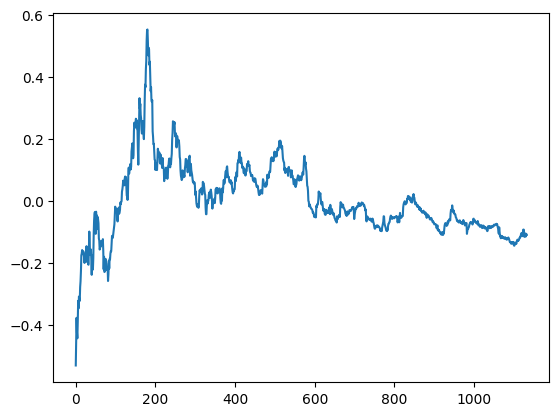

In [ ]:
spread= (s73 - (model.coef_* s9 + model.intercept_)).squeeze()
plt.plot(spread)

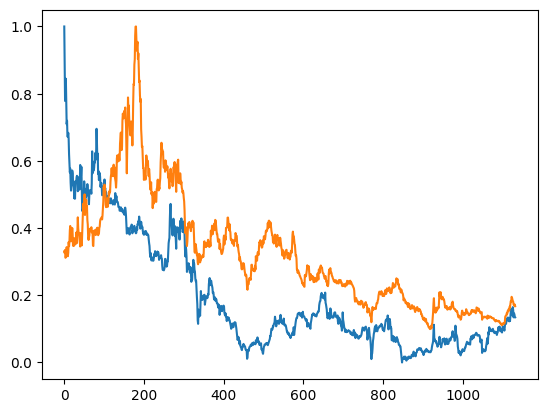

In [ ]:
plt.plot(s9)
plt.plot(s73)
plt.show()

In [ ]:
# mr_spy_iwm.py

def calculate_spread_zscore(pairs, symbols, lookback=100):
    """
    Creates a hedge ratio between the two symbols by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    symbols based on a linear combination of the two.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        A DataFrame containing Close price for SPY and IWM. Index is a
        Datetime object.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.
    lookback : `int`, optional (default: 100)
        Lookback preiod for rolling linear regression.

    Returns
    -------
    pairs : 'pd.DataFrame'
        Updated DataFrame containing the spread and z score between
        the two symbols based on the rolling linear regression.
    """

    def adaptive_zscore(series, window):
      zscores = []
      for i in range(len(series)):
          if i == 0:
              zscores.append(0)  # First value is always 0
          else:
              start = max(0, i - window)
              data_window = series[start:i]  # up to but not including i
              mean = data_window.mean()
              std = data_window.std(ddof=0)
              z = (series[i] - mean) / std if std != 0 else 0
              zscores.append(z)
      return pd.Series(zscores, index=series.index)

    # Use the statsmodels Rolling Ordinary Least Squares method to fit
    # a rolling linear regression between the two closing price time series
    print("Fitting the rolling Linear Regression...")

    model = RollingOLS(
        endog=pairs[symbols[0]],
        exog=sm.add_constant(pairs[symbols[1]]),
        window=lookback,
        expanding=True
    )
    rres = model.fit()
    params = rres.params.copy()


    # Construct the hedge ratio and eliminate the first
    # lookback-length empty/NaN period
    pairs['hedge_ratio'] = params[symbols[1]]
    pairs.dropna(inplace=True)

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    pairs['spread'] = (
        pairs[symbols[0]] - pairs['hedge_ratio']*pairs[symbols[1]]
    )
    expanding_df = pairs.expanding()
    pairs['zscore'] = adaptive_zscore(pairs["spread"], lookback)
    pairs.loc[pairs.index[0], "zscore"]=0
    return pairs

pair = pd.DataFrame({"stock1":s9 , "stock2":s73})
pair= calculate_spread_zscore(pair, ("stock1", "stock2"))

Fitting the rolling Linear Regression...
Creating the spread/zscore columns...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


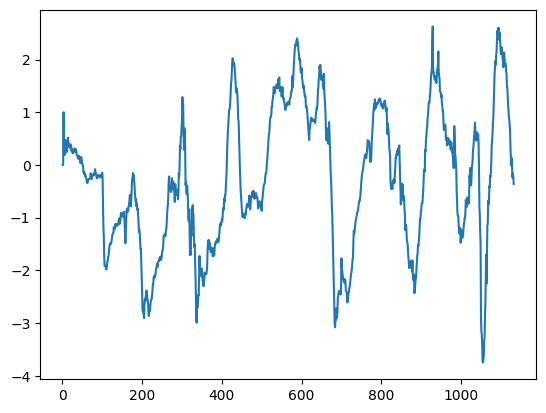

In [ ]:
plt.plot(pair["zscore"])

In [ ]:
# mr_spy_iwm.py

def create_long_short_market_signals(
        pairs, z_entry_threshold=2.0, z_exit_threshold=1.0
    ):
    """
    Create the entry/exit signals based on the exceeding of z_entry_threshold
    for entering a position and falling below z_exit_threshold for exiting
    a position.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        Updated DataFrame containing the close price, spread and z score
        between the two symbols.
    z_entry_threshold : `float`, optional (default:2.0)
        Z Score threshold for market entry.
    z_exit_threshold : `float`, optional (default:1.0)
        Z Score threshold for market exit.

    Returns
    -------
    pairs : `pd.DataFrame`
        Updated DataFrame containing long, short and exit signals.
    """

    # Calculate when to be long, short and when to exit
    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
    pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold)*1.0

    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print("Calculating when to be in the market (long and short)...")
    for i, b in enumerate(pairs.iterrows()):
        # Calculate longs
        if b[1]['longs'] == 1.0:
            long_market = 1
        # Calculate shorts
        if b[1]['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b[1]['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        pairs.at[pairs.index[i], 'long_market'] = long_market
        pairs.at[pairs.index[i], 'short_market'] = short_market

    return pairs
pair= create_long_short_market_signals(pair, z_entry_threshold=1.5, z_exit_threshold= 0.5).copy()

Calculating when to be in the market (long and short)...


In [ ]:
pair.describe()

,stock1,stock2,hedge_ratio,spread,zscore,longs,shorts,exits,long_market,short_market
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000
mean,0.194879,0.319555,0.089451,0.210498,-0.264372,0.195230,0.100707,0.257067,0.318021,0.176678
std,0.171759,0.168795,1.129295,0.488205,1.332035,0.396553,0.301073,0.437210,0.465914,0.381565
min,0.000000,0.099347,-9.593436,-6.767815,-3.747792,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.070837,0.176189,-0.247093,-0.032017,-1.227341,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.120515,0.281250,0.228478,0.046175,-0.266366,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.311177,0.395756,0.511582,0.262533,0.796460,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.879485,1.000000,23.489698,3.991016,2.626889,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# mr_spy_iwm.py

def create_portfolio_returns(pairs, symbols):
    """
    Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios.

    Parameters
    ----------
    pairs : `pd.DataFrame`
        Updated DataFrame containing the close price, spread and z score
        between the two symbols and the long, short and exit signals.
    symbols : `tup`
        Tuple containing ticker symbols as `str`.

    Returns
    -------
    portfolio : 'pd.DataFrame'
        A DataFrame with datetime index from the pairs DataFrame, positions,
        total market value and returns.
    """

    # Convenience variables for symbols

    # Construct the portfolio object with positions information
    # Note the minuses to keep track of shorts!
    print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=pairs.index)
    portfolio['positions'] = pairs['long_market'] - pairs['short_market']
    portfolio[symbols[0]] = portfolio['positions'] * 1.0 * pairs[symbols[0]]
    portfolio[symbols[1]] = portfolio['positions'] * (-pairs['hedge_ratio']) * pairs[symbols[1]]

    portfolio['total'] = portfolio[symbols[0]] + portfolio[symbols[1]]

    # Construct a percentage returns stream and eliminate all
    # of the NaN and -inf/+inf cells
    entry_spread = None
    position = 0  # 1 for long, -1 for short, 0 for no position
    rewards = []

    for i in range(len(pairs)):
        current_spread = pairs['spread'].iloc[i]
        long_signal = pairs['long_market'].iloc[i]
        short_signal = pairs['short_market'].iloc[i]

        # Entry
        if position == 0:
            if long_signal == 1:
                position = 1
                entry_spread = current_spread
            elif short_signal == 1:
                position = -1
                entry_spread = current_spread
            rewards.append(0.0)

        # Exit
        elif (long_signal == 0 and position == 1) or (short_signal == 0 and position == -1):
            reward = (entry_spread - current_spread) * position
            rewards.append(reward)
            position = 0
            entry_spread = None

        # Hold
        else:
            rewards.append(0.0)

    portfolio['reward'] = rewards

    portfolio['cumulative_reward'] = pd.Series(rewards).cumsum().values

    return portfolio

port= create_portfolio_returns(pair, ("stock1", "stock2"))

Constructing a portfolio...


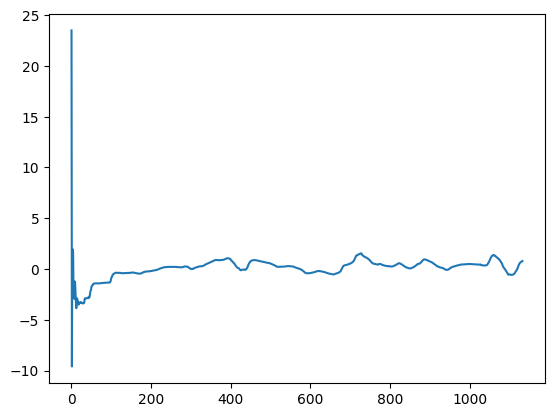

In [ ]:
plt.plot(pair["hedge_ratio"])

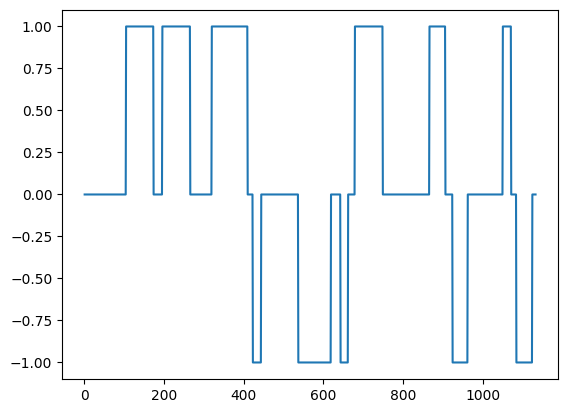

In [ ]:
plt.plot(port["positions"])

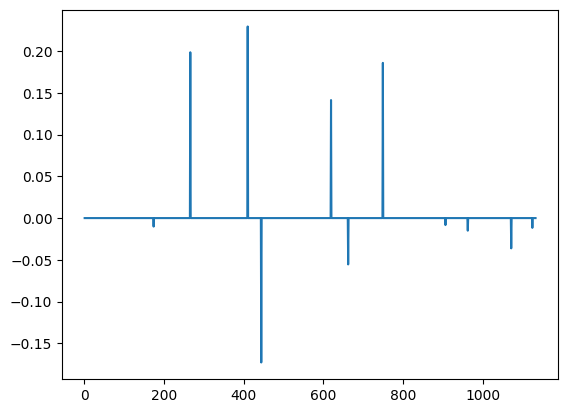

In [ ]:
plt.plot(port["reward"])

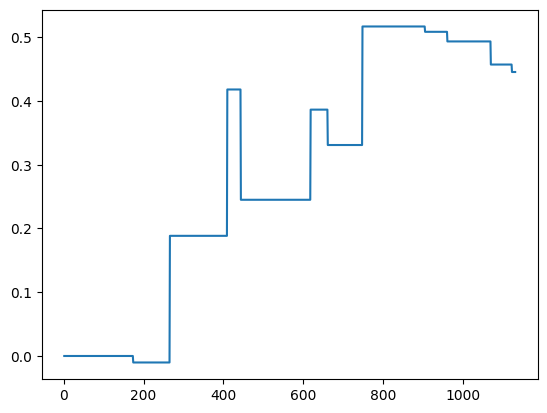

In [ ]:
plt.plot(port["cumulative_reward"])

In [ ]:
def backtest(thres, stock1, stock2, spread):
  profit=[]

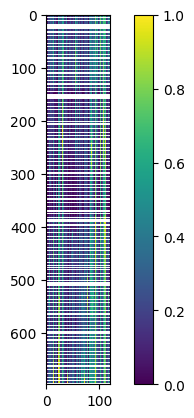

In [ ]:
plt.imshow(normalized[5000:], cmap='viridis', interpolation='nearest')
plt.colorbar()